*Copyright 2024 Google LLC.*

*Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at*

     http://www.apache.org/licenses/LICENSE-2.0

*Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.*

# Advanced: Using custom machine learning and data processing packages

[![Open in Colab](https://img.shields.io/badge/Open_in_Colab-blue?style=flat&logo=google%20colab&labelColor=grey)](https://colab.research.google.com/github/google-marketing-solutions/fractional_uplift/blob/main/examples/using_custom_ml_and_data_processing_packages.ipynb)  
[![Open in Github](https://img.shields.io/badge/Open_in_Github-blue?style=flat&logo=Github&labelColor=grey)](https://github.com/google-marketing-solutions/fractional_uplift/blob/main/examples/using_custom_ml_and_data_processing_packages.ipynb)  
[![Open in NBViewer](https://img.shields.io/badge/Open_in_NBViewer-blue?style=flat&logo=jupyter&labelColor=grey)](https://nbviewer.org/github/google-marketing-solutions/fractional_uplift/blob/main/examples/using_custom_ml_and_data_processing_packages.ipynb)

This demo shows how you can use fractional uplift with any data processing and ML packages, in case you would rather not use [Pandas](https://pandas.pydata.org/) and [Tensorflow Decision Forests](https://www.tensorflow.org/decision_forests), which are the defaults that are already implemented. This allows Fractional Uplift to integrate with any tech stack you might have (as long as it's python based).

For this example, we will assume we want to use [Numpy](https://numpy.org/) arrays for data processing instead of pandas, and [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) and [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) from scikit-learn for the machine learning.

**Note: this notebook assumes you are already familiar with Fractional Uplift. If you are not, it's best to first go through the [end to end demo](https://github.com/google-marketing-solutions/fractional_uplift/blob/main/examples/end_to_end_example.ipynb).**

In [ ]:
# Install the packages if necessary
! pip install -q fractional-uplift pandas numpy tensorflow matplotlib scikit-learn==1.0.2

In [2]:
from typing import Any, Optional

import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn import linear_model
from sklearn import preprocessing
from sklearn import pipeline

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.lines import Line2D


try:
  import google.colab
  google.colab.data_table.enable_dataframe_formatter()
  IN_COLAB = True
except:
  IN_COLAB = False

In [ ]:
import fractional_uplift as fr

In [3]:
# Define some short cuts to useful variables

KPI = fr.constants.KPI
Task = fr.constants.Task
TaskType = fr.constants.TaskType

Dataset = fr.datasets._base.Dataset
TrainData = fr.datasets._base.TrainData
BaseModel = fr.base_models.BaseModel

## Define the Plotting Functions

This function is used to plot the uplift curves for evaluation.

In [4]:
def plot_cumulative_incrementality(
    ax: plt.Axes,
    results_data: pd.DataFrame,
    model_names: dict[str, str],
    x_col: str,
    y_col: str,
    title: str = "",
    x_label: str | None = None,
    y_label: str | None = None,
    x_format: str = "{0}",
    y_format: str = "{0}",
    order_col: str = "share_targeted",
    random_baseline_name: str = "random",
    x_lim: list[float] | None = None,
    y_lim: list[float] | None = None,
    show_legend: bool = True,
  ) -> None:
  """Plots the cumulative incrementality of any x and y metrics."""

  baselines_data = results_data.loc[results_data.name == random_baseline_name].copy().sort_values(order_col)
  models_data = results_data.loc[results_data.name.isin(model_names)].copy().sort_values(order_col)

  raw_model_names = list(model_names.keys())
  clean_model_names = list(model_names.values())

  ax.plot(baselines_data[x_col], baselines_data[y_col], color="k", lw=1, label="")

  for raw_model_name, model_results in models_data.groupby("name"):

    if raw_model_name.endswith("_distill"):
      raw_model_name = raw_model_name.removesuffix("_distill")
      label = ""
      line_style = "--"
    else:
      label = model_names[raw_model_name]
      line_style = "-"

    color = f"C{raw_model_names.index(raw_model_name)}"
    ax.plot(model_results[x_col], model_results[y_col], color=color, lw=1.5, label=label, ls=line_style)

  if x_lim is not None:
    ax.set_xlim(x_lim)
  if y_lim is not None:
    ax.set_ylim(y_lim)

  ax.set_xlabel(x_label or x_col)
  ax.set_ylabel(y_label or y_col)
  ax.set_title(title)

  ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: x_format.format(x)))
  ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, pos: y_format.format(y)))

  # Add legend
  if show_legend:
    handles, labels = ax.get_legend_handles_labels()
    handles.extend([
        Line2D([0], [0], alpha=0.0),
        Line2D([0], [0], color="0.7", lw=1.5, ls="-"),
        Line2D([0], [0], color="0.7", lw=1.5, ls="--")
    ])
    labels.extend([
        "",
        "Full model",
        "Distilled model"
    ])
    _ = ax.legend(
        handles=handles,
        labels=labels,
        loc='upper left',
        bbox_to_anchor=(1, 1)
    )

  del(baselines_data)
  del(models_data)

## Create custom data processing

To use a custom data processing package, we must subclass the `Dataset` and `TrainData` classes.

The `Dataset` is a simple class that allows a dataset to be transformed between different formats. For example it allows the data to be converted into a tensorflow dataset so that it can be used with tensorflow decision forests.

The `TrainData` class produces `Dataset` objects by taking a single training data sample and selecting different columns to be the target or weights. This is what is passed to the different uplift models, which can then use this to train the appropriate meta learner.

### `NumpyDataset` Subclass

Below is a minimal example of how to create a numpy based dataset class. It doesn't implement any validation of the inputs, and would only work with our linear regression model that will be implemented in the next section.

For the dataset to be able to integrate with other models, then the appropriate data connector method must also be implemented. For example, to make it work with tensorflow_decision_forests, you must implement the `as_tf_dataset()` method of the Dataset. Here for simplicity we don't do that.

For a more complete example, look at the implementation of the `PandasDataset`.

In [5]:
class NumpyDataset(Dataset):

  def __init__(
      self,
      features: np.ndarray,
      *,
      task: Optional[TaskType] = None,
      labels: np.ndarray | None = None,
      weights: np.ndarray | None = None,
      shuffle: bool = False,
      copy: bool = True
    ):
    super().__init__(
        features=features,
        task=task,
        labels=labels,
        weights=weights,
        shuffle=shuffle,
        copy=copy,
    )
    self.task = task

    self.features = features
    self.labels = labels
    self.weights = weights

    if copy:
      self.features = features.copy()
      if self.labels is not None:
        self.labels = labels.copy()
      if self.weights is not None:
        self.weights = weights.copy()

    if shuffle:
      rng = np.random.default_rng()
      shuffle_idx = np.arange(features.shape[0])
      rng.shuffle(shuffle_idx)

      self.features = self.features[shuffle_idx, :]
      if self.labels is not None:
        self.labels = self.labels[shuffle_idx]
      if self.weights is not None:
        self.weights = self.weights[shuffle_idx]

  def as_arrays(self) -> tuple[np.ndarray, np.ndarray | None, np.ndarray | None]:
    """Returns the dataset as a tuple of numpy arrays.

    The first array is the features, the second is the labels, and the third is the weights.
    The labels and weights are None if they do not exist.
    """
    return self.features, self.labels, self.weights

  def as_pd_dataframe(self) -> pd.DataFrame:
    """NOT IMPLEMENTED. Returns the dataset as a pandas dataframe.

    If they exist, the labels are in the column named "label_" and weights in a
    column named "weight_".
    """
    raise NotImplementedError("Must implement as_pd_dataframe() to use this.")

  def as_tf_dataset(self) -> tf.data.Dataset:
    """NOT IMPLEMENTED. Returns the dataset as a tensorflow dataset object.

    For a full implementation this should be implemented as well, but
    """
    raise NotImplementedError("Must implement as_tf_dataset() to use this.")

  def labels_are_constant(self) -> bool | None:
    """Are the labels constant?

    Returns true if the labels are the same for every row in the dataset,
    false otherwise, and None if there are no labels.
    """
    if self.labels is None:
      return None
    return np.allclose(self.labels, self.labels[0])

  def label_average(self) -> float | None:
    """Return the average label."""
    if self.labels is None:
      return None
    return np.sum(self.labels * self.weights) / np.sum(self.weights)

  def __len__(self) -> int:
    """Returns the number of samples in the dataset."""
    return self.features.shape[0]

### `NumpyTrainData` Subclass

This class managed the whole training data, producing the different datasets required by each of the different meta learners. We will create a numpy version, that will produce instances of the `NumpyDataset` we defined above.

In [6]:
class NumpyTrainData(TrainData):

  def __init__(
      self,
      features: np.ndarray,
      maximize_kpi: np.ndarray,
      is_treated: np.ndarray,
      treatment_propensity: np.ndarray,
      constraint_kpi: np.ndarray | None = None,
      constraint_offset_kpi: np.ndarray | None = None,
      sample_weight: np.ndarray | None = None,
    ):

    super().__init__()
    self.features = features
    self.maximize_kpi = maximize_kpi
    self.is_treated = is_treated
    self.treatment_propensity = treatment_propensity
    self.constraint_kpi = constraint_kpi
    self.constraint_offset_kpi = constraint_offset_kpi

    self.kpis = {
        KPI.MAXIMIZE_KPI.name: self.maximize_kpi,
        KPI.CONSTRAINT_KPI.name: self.constraint_kpi,
        KPI.CONSTRAINT_OFFSET_KPI.name: self.constraint_offset_kpi,
    }

    if sample_weight is None:
      self.sample_weight = np.ones_like(maximize_kpi)
    else:
      self.sample_weight = sample_weight

  @property
  def inverse_propensity_weights(self) -> np.ndarray:
    """Returns the inverse propensity weights.

    This is based on is_treated and treatment_propensity. The sample is weighed
    inversely to the propensity that it would have been assiged to its
    treatment group.

    If is_treated = 1, it's weighed by 1 / treatment_propensity
    If is_treated = 0, it's weighed by 1 / (1 - treatment_propensity)
    """
    ipw_control = self.is_treated  / self.treatment_propensity
    ipw_treated = (1 - self.is_treated) / (1.0 - self.treatment_propensity)
    ipw = ipw_control + ipw_treated
    return ipw

  def _get_inc_classifier_data(self, kpi: KPI) -> NumpyDataset | None:
    """Returns the dataset to train an incrementality classifier model.

    - The label should be whether the sample is treated or not.
    - The weight should be the sample weight multiplied by the KPI, adjusted for the treatment propensity.

    If the kpi does not exist this should return None.

    Args:
      kpi: The kpi to get the dataset for.
    """
    kpi_values = self.kpis[kpi.name]

    if kpi_values is None:
      # KPI does not exist
      return None

    weights = kpi_values * self.inverse_propensity_weights * self.sample_weight
    return NumpyDataset(
        self.features,
        labels=self.is_treated,
        weights=weights,
        shuffle=True,
        task=Task.CLASSIFICATION
    )

  def _get_kpi_weight_data(self) -> NumpyDataset | None:
    """Returns the dataset to train the kpi weight model.

    This dataset is used to train a multi-class classifier.
    - This should be a concatenation of two or three copies of the dataset.
    - Each copy should be for each non-null kpi.
    - The label should be an identifier of the kpi of that copy.
    - The weight should be the sample weight multiplied by the KPI, adjusted for the treatment propensity.

    If the only kpi that is set is the maximize_kpi kpi, then this
    should return None, as no kpi weight model is needed.

    Must be defined in the subclass. Do not use this directly, instead use
    get_kpi_weight_data() which caches the result automatically.
    """
    if not self.has_kpi(KPI.CONSTRAINT_KPI):
      # We only have the maximize_kpi kpi, so no model needed
      return None

    features_lst = [self.features]
    labels_lst = [KPI.MAXIMIZE_KPI.value] * len(self.maximize_kpi)
    weights_lst = [
        self.maximize_kpi * self.inverse_propensity_weights * self.sample_weight
    ]

    features_lst.append(self.features)
    labels_lst += [KPI.CONSTRAINT_KPI.value] * len(self.constraint_kpi)
    weights_lst.append(
        self.constraint_kpi
        * self.inverse_propensity_weights
        * self.sample_weight
    )

    if self.constraint_offset_kpi is not None:
      features_lst.append(self.features)
      labels_lst += [KPI.CONSTRAINT_OFFSET_KPI.value] * len(
          self.constraint_offset_kpi
      )
      weights_lst.append(
          self.constraint_offset_kpi
          * self.inverse_propensity_weights
          * self.sample_weight
      )

    features = np.concatenate(features_lst, axis=0)
    labels = np.array(labels_lst)
    weights = np.concatenate(weights_lst)

    return NumpyDataset(
        features,
        labels=labels,
        weights=weights,
        shuffle=True,
        task=Task.CLASSIFICATION
    )


  def _get_data_for_single_treatment(
      self, kpi: KPI, is_treated: bool
  ) -> NumpyDataset | None:
    """Returns the dataset for specfied value of is_treated.

    If the kpi does not exist, it returns None.

    Args:
      kpi: The kpi to get the dataset for.
      is_treated: Get the treatment group (True) or control group (False).
    """
    kpi_values = self.kpis[kpi.name]

    if kpi_values is None:
      # KPI does not exist
      return None

    # is_treated is an int in the data, not bool
    treatment_mask = self.is_treated == int(is_treated)

    weights = (
        self.inverse_propensity_weights[treatment_mask]
        * self.sample_weight[treatment_mask]
    )

    return NumpyDataset(
        self.features[treatment_mask, :],
        labels=kpi_values[treatment_mask],
        weights=weights,
        shuffle=True,
        task=Task.REGRESSION
    )

  def has_kpi(self, kpi: KPI) -> bool:
    """Returns True if the kpi exists in this dataset."""
    return self.kpis.get(kpi.name) is not None

  def has_non_negative_kpi(self, kpi: KPI) -> bool:
    """Returns True if the kpi exists in this dataset and is non-negative."""
    if self.kpis.get(kpi.name) is None:
      return False

    return np.all(self.kpis.get(kpi.name) >= 0.0)

## Create custom modelling

Now we will subclass the model class to create a linear regression model, built on top of scikit-learn.

*Note: if all we wanted to do was use linear regression as a model, we wouldn't have needed to create the new train data and dataset classes, because numpy works with pandas too. We are just doing that here to demonstrate how to create a completely custom setup.*

### `LinearRegressionModel` Subclass

This model will use either `LinearRegression` for a regression task for `LogisticRegression` for a classification task, both without any penalty. For a real world use-case these will probably not work well, but for this demo they are sufficient.

In [7]:
class LinearRegressionModel(BaseModel):

  def __init__(self, init_kw: dict[str, Any] | None = None, fit_kw: dict[str, Any] | None = None):
    super().__init__()

    self._store_params(
        init_kw=init_kw,
        fit_kw=fit_kw,
    )

    self.init_kw = init_kw or {}
    self.fit_kw = fit_kw or {}

  def _fit(self, train_data: NumpyDataset) -> None:
    """Fits the model using the train_data.

    Args:
      train_data: The training data for the model
      **fit_kw: All keyword args are passed to the model fit function
    """
    features, labels, weights = train_data.as_arrays()
    self._task = train_data.task
    if self._task == Task.REGRESSION:
      model = linear_model.LinearRegression(**self.init_kw)
    elif self._task == Task.CLASSIFICATION:
      model = linear_model.LogisticRegression(penalty="none", **self.init_kw)
    else:
      raise ValueError(f"Invalid task: {train_data.task}")

    self.model = pipeline.Pipeline(steps=[
        ("scaler", preprocessing.StandardScaler()),
        ("model", model)
    ])
    self.model.fit(features, labels, model__sample_weight=weights, **self.fit_kw)

  def _predict(self, data: NumpyDataset) -> np.ndarray:
    """Makes predictions using the model.

    Args:
      data: The data to make predictions from.
    """
    features, _, _ = data.as_arrays()

    if self._task == Task.REGRESSION:
      preds = self.model.predict(features)
    elif self._task == Task.CLASSIFICATION:
      preds = self.model.predict_proba(features)
      if np.shape(preds)[1] == 2:
        # For a binary classification, our predict function must return
        # a 1-d array with the probability of the positive class.
        preds = preds[:, 1]
    else:
      raise ValueError(f"Invalid task: {train_data.task}")

    return preds

  def export(self) -> Any:
    """Exports the underlying model.

    Returns:
      The underlying model for integration with external
        pipelines outside of this package.
    """
    return self.model

## Perform fractional uplift modelling

Now we will use our custom classes to perform fractional uplift modelling. Let's assume we want to use the marketing objective of minimizing the cost per incremental conversion: Min CPiA. This means our maximize kpi is conversions, and our constraint kpi is cost, and there is no constraint offset kpi.

### Load the Criteo Data

We will again be using the [Criteo dataset](https://ailab.criteo.com/criteo-uplift-prediction-dataset/) to demo this notebook. First let's load it in (this can take a couple of minutes).

In [8]:
criteo = fr.example_data.CriteoWithSyntheticCostAndSpend.load()

In [9]:
criteo.train_data.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,treatment_propensity,cost_percentage,spend,cost,sample_weight
44,12.616365,10.059654,8.964588,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0.85,0.000000,0.000000,0.000000,100.0
187,12.616365,10.059654,8.904597,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0.85,0.000000,0.000000,0.000000,100.0
484,22.377238,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0.85,0.000000,0.000000,0.000000,100.0
528,12.616365,10.059654,8.350682,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,16.226044,5.300375,-0.168679,1,0,0.85,0.000000,0.000000,0.000000,100.0
1108,14.617627,10.059654,8.489929,3.907662,13.253813,4.115453,-2.411115,4.833815,3.809530,42.176324,5.737292,-0.560340,1,1,0.85,0.090777,36.459294,3.309655,1.0


The criteo data is loaded as pandas dataframes, but in this example we want to use numpy instead of pandas, so let's convert this into some numpy arrays.

In [10]:
X_train = criteo.train_data[criteo.features].values
cost_train = criteo.train_data["cost"].values
conversion_train = criteo.train_data["conversion"].values
is_treated_train = criteo.train_data["treatment"].values
treatment_propensity_train = criteo.train_data["treatment_propensity"].values
sample_weight_train = criteo.train_data["sample_weight"].values

X_test = criteo.test_data[criteo.features].values
cost_test = criteo.test_data["cost"].values
conversion_test = criteo.test_data["conversion"].values
is_treated_test = criteo.test_data["treatment"].values
treatment_propensity_test = criteo.test_data["treatment_propensity"].values
sample_weight_test = criteo.test_data["sample_weight"].values

X_distill = criteo.distill_data[criteo.features].values
cost_distill = criteo.distill_data["cost"].values
conversion_distill = criteo.distill_data["conversion"].values
is_treated_distill = criteo.distill_data["treatment"].values
treatment_propensity_distill = criteo.distill_data["treatment_propensity"].values
sample_weight_distill = criteo.distill_data["sample_weight"].values

### Create the train data and test / distill datasets

In [11]:
test_dataset = NumpyDataset(features=X_test)
distill_dataset = NumpyDataset(features=X_distill)

In [12]:
train_data = NumpyTrainData(
    features=X_train,
    maximize_kpi=conversion_train,
    constraint_kpi=cost_train,
    is_treated=is_treated_train,
    treatment_propensity=treatment_propensity_train,
    sample_weight=sample_weight_train
)

### Train the meta learners

These are the fractional uplift models. We will try out 4 different uplift models and compare them. Now we've implemented the models and datasets above, we are able to make use of all of the meta learners in Fractional Uplift without any extra work.

In [13]:
# Train the T-Learner
t_learner = fr.meta_learners.TLearner(LinearRegressionModel())
t_learner.fit(train_data)
criteo.test_data["t_learner_score"] = t_learner.predict(test_dataset)

# Train the RetrospectiveEstimation
retro_est_learner = fr.meta_learners.RetrospectiveLearner(LinearRegressionModel())
retro_est_learner.fit(train_data)
criteo.test_data["retro_est_learner_score"] = retro_est_learner.predict(test_dataset)

# Train the FractionalLearner
frac_learner = fr.meta_learners.FractionalLearner(LinearRegressionModel())
frac_learner.fit(train_data)
criteo.test_data["frac_learner_score"] = frac_learner.predict(test_dataset)

# Train the FractionalRetrospectiveEstimation
frac_retro_est_learner = fr.meta_learners.FractionalRetrospectiveLearner(LinearRegressionModel())
frac_retro_est_learner.fit(train_data)
criteo.test_data["frac_retro_est_learner_score"] = frac_retro_est_learner.predict(test_dataset)

constraint_kpi_inc_model not set, duplicating maximize_kpi_inc_model.
constraint_offset_kpi_inc_model not set, duplicating maximize_kpi_inc_model.
kpi_weight_model not set, duplicating maximize_kpi_inc_model.


### Evaluate Models

We want to find the model that will deliver the most incremental conversions, at the lowest possible cost per incremental conversion. To do that we will make a CPiA evaluator, which will evaluate the CPiA as a function of the model score:

In [14]:
class CPIAUpliftEvaluator(fr.evaluate.UpliftEvaluator):
  def __init__(self, **kwargs):
    kwargs["metric_cols"] = ["spend", "conversion", "cost"]
    super().__init__(**kwargs)

  def _calculate_composite_metrics(self, data: pd.DataFrame) -> pd.DataFrame:
    data["cpia__inc_cum"] = data["cost__inc_cum"] / data["conversion__inc_cum"]
    data["cpia__inc"] = data["cost__inc"] / data["conversion__inc"]
    return data

Now we can evaluate the models and plot the results below.

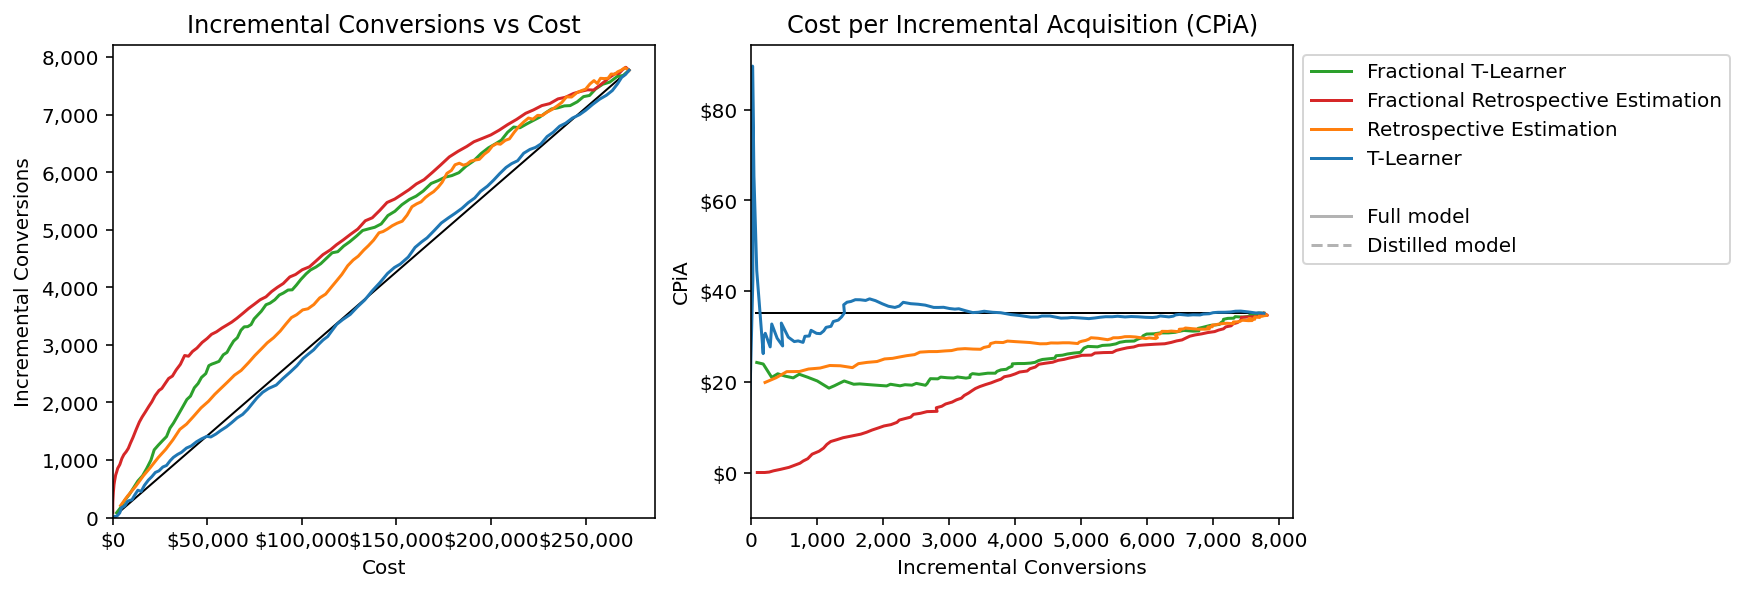

In [15]:
evaluator = CPIAUpliftEvaluator(
    is_treated_col="treatment",
    treatment_propensity_col="treatment_propensity",
    effect_type=fr.EffectType.ATE
)

models = {
    "t_learner_score": "T-Learner",
    "retro_est_learner_score": "Retrospective Estimation",
    "frac_learner_score": "Fractional T-Learner",
    "frac_retro_est_learner_score": "Fractional Retrospective Estimation",
}

results = evaluator.evaluate(criteo.test_data, score_cols=list(models.keys()))

fig, axs = plt.subplots(ncols=2, figsize=(12, 4), constrained_layout=True)

plot_cumulative_incrementality(
    axs[0],
    results,
    title="Incremental Conversions vs Cost",
    model_names=models,
    x_col="cost__inc_cum",
    y_col="conversion__inc_cum",
    x_label="Cost",
    y_label="Incremental Conversions",
    x_format="${:,.0f}",
    y_format="{:,.0f}",
    x_lim=[0, None],
    y_lim=[0, None],
    show_legend=False
)

plot_cumulative_incrementality(
    axs[1],
    results,
    title="Cost per Incremental Acquisition (CPiA)",
    model_names=models,
    x_col="conversion__inc_cum",
    y_col="cpia__inc_cum",
    x_label="Incremental Conversions",
    y_label="CPiA",
    x_format="{:,.0f}",
    y_format="${:,.0f}",
    x_lim=[0, None]
)

plt.show()

It looks like the Fractional Retrospecitve Estimation is the best. We can get 2000 incremental conversions with ~$10 CPiA. None of the other models achieve that.

### Model deployment

Now we want to deploy the model, so we will distill it, and extract the underlying scikit-learn pipeline. This can then be saved and deployed as you would with a regular scikit-learn model.

First we distill the model into a single linear regression model.

In [16]:
distill_learner = LinearRegressionModel()
frac_retro_est_learner.distill(distill_dataset, distill_learner)
criteo.test_data["frac_retro_est_learner_score_distill"] = distill_learner.predict(test_dataset)

Now let's evaluate again to check that the model was distilled well. The distilled model should roughly match the original models performance.

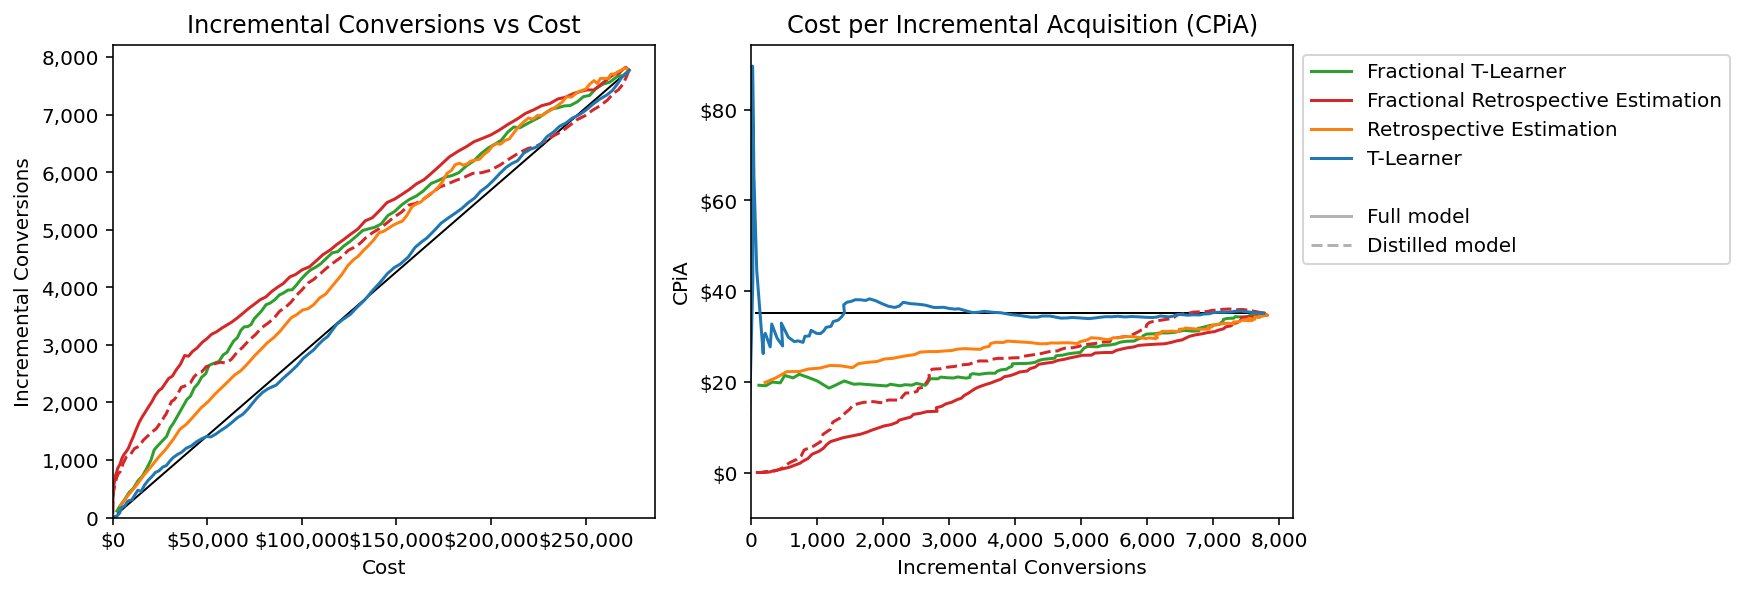

In [17]:
evaluator = CPIAUpliftEvaluator(
    is_treated_col="treatment",
    treatment_propensity_col="treatment_propensity",
    effect_type=fr.EffectType.ATE
)

models = {
    "t_learner_score": "T-Learner",
    "retro_est_learner_score": "Retrospective Estimation",
    "frac_learner_score": "Fractional T-Learner",
    "frac_retro_est_learner_score": "Fractional Retrospective Estimation",
    "frac_retro_est_learner_score_distill": "Fractional Retrospective Estimation",
}

results = evaluator.evaluate(criteo.test_data, score_cols=list(models.keys()))

fig, axs = plt.subplots(ncols=2, figsize=(12, 4), constrained_layout=True)

plot_cumulative_incrementality(
    axs[0],
    results,
    title="Incremental Conversions vs Cost",
    model_names=models,
    x_col="cost__inc_cum",
    y_col="conversion__inc_cum",
    x_label="Cost",
    y_label="Incremental Conversions",
    x_format="${:,.0f}",
    y_format="{:,.0f}",
    x_lim=[0, None],
    y_lim=[0, None],
    show_legend=False
)

plot_cumulative_incrementality(
    axs[1],
    results,
    title="Cost per Incremental Acquisition (CPiA)",
    model_names=models,
    x_col="conversion__inc_cum",
    y_col="cpia__inc_cum",
    x_label="Incremental Conversions",
    y_label="CPiA",
    x_format="{:,.0f}",
    y_format="${:,.0f}",
    x_lim=[0, None]
)

plt.show()

Not bad, it doesn't 100% match the performance of the original learner, but it does well enough. Now we can export it.

In [18]:
exported_model = distill_learner.export()
print(type(exported_model))

<class 'sklearn.pipeline.Pipeline'>


Now you can deploy the exported model however you would normally deploy a scikit-learn pipeline.